In [1]:
import os
import cv2
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [2]:
img_size = 400
vgg = tf.keras.applications.VGG19(include_top = False, input_shape=(img_size, img_size, 3), weights = "imagenet")
vgg.trainable = False
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


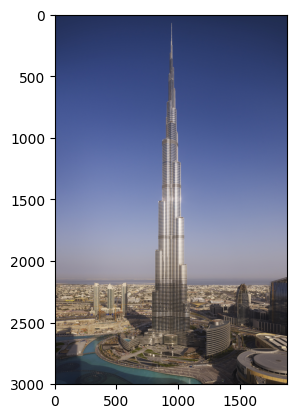

In [3]:
content_image = cv2.imread(r"C:\Users\robel\Downloads\Burj_khalifa.jpg")
content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2RGB)
plt.imshow(content_image)


In [4]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- a scalar value
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    _, n_H, n_W, n_C = a_C.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape=[1,n_H*n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[1,n_H*n_W, n_C])
    
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/ (4 * n_H * n_W * n_C)
 
    
    return J_content

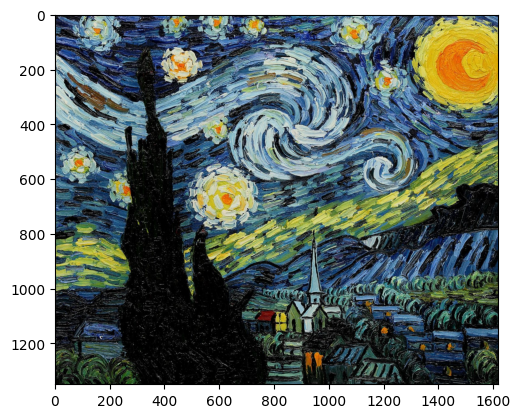

In [5]:
style_image = cv2.imread(r"C:\Users\robel\Downloads\pacasso_drawing.jpg")
style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
plt.imshow(style_image)

In [7]:
def compute_layer_style_cost(a_S, a_G):
    """
    Compute the style cost for a given layer.
    
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns:
    J_style_layer -- tensor representing a scalar value, style cost
    """
    # Retrieve dimensions from a_S
    _, n_H, n_W, n_C = a_S.get_shape().as_list()
    
    # Reshape the tensors to have shape (n_H * n_W, n_C)
    a_S = tf.reshape(a_S, shape=(n_H * n_W, n_C))
    a_G = tf.reshape(a_G, shape=(n_H * n_W, n_C))
    
    # Compute Gram matrices for both style and generated images
    GS = tf.matmul(tf.transpose(a_S), a_S)
    GG = tf.matmul(tf.transpose(a_G), a_G)

    # Compute the style loss
    J_style_layer = tf.reduce_sum(tf.square(GS - GG)) / (4.0 * (n_C ** 2) * (n_H * n_W) ** 2)
    
    return J_style_layer
    


In [8]:
#The layers I chose to calculate the style loss
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]


In [9]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [10]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost
    """

    J = alpha*J_content + beta*J_style

    return J

(1, 400, 400, 3)


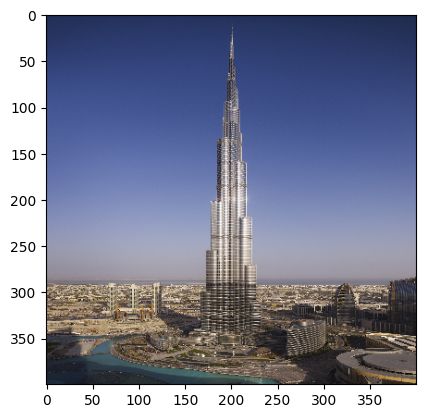

In [11]:
new_size = (img_size, img_size)  # (width, height)
content_image = cv2.resize(content_image, new_size, interpolation=cv2.INTER_LINEAR)
content_image = tf.constant(content_image)

# Resize the image using tf.image.resize
content_image = tf.expand_dims(content_image, axis=0)
c_img = content_image.numpy()[0]
print(content_image.shape)
plt.imshow(c_img)

(1, 400, 400, 3)


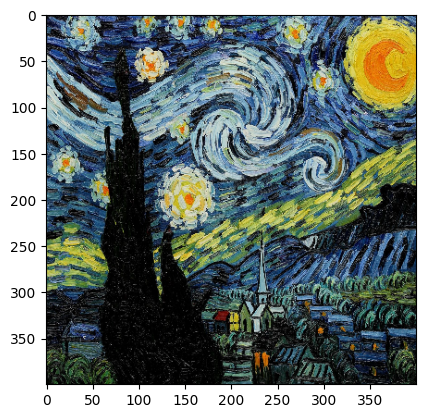

In [12]:
style_image = cv2.resize(style_image, new_size, interpolation=cv2.INTER_LINEAR)
style_image = tf.constant(style_image)
style_image = tf.expand_dims(style_image, axis=0)
s_img = style_image.numpy()[0]
print(style_image.shape)
plt.imshow(s_img)


(1, 400, 400, 3)


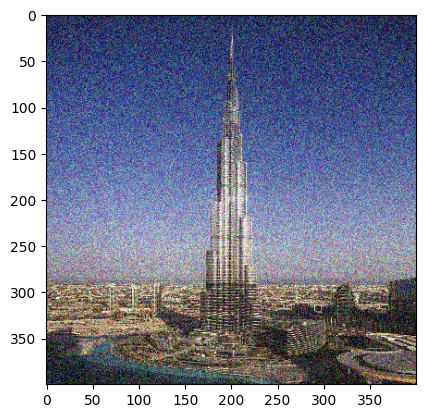

In [13]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

In [14]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [15]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [16]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

In [17]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [18]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
def tensor_to_image_cv(tensor):
    """
    Converts the given tensor into an OpenCV image.
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    image: An OpenCV image (NumPy array)
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1  # Ensure batch dimension is 1
        tensor = tensor[0]  # Remove the batch dimension
    if tensor.shape[2] == 3:  # Check if image has 3 channels (RGB)
        tensor = cv2.cvtColor(tensor, cv2.COLOR_RGB2BGR)
    return tensor


In [20]:



optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        
        a_G = vgg_model_outputs(generated_image)  
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)
        # a_S represents the style image activations

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)  
        
        # Compute the total cost
        J = total_cost(J_content, J_style)
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

In [21]:
generated_image = tf.Variable(generated_image)

Epoch 0 


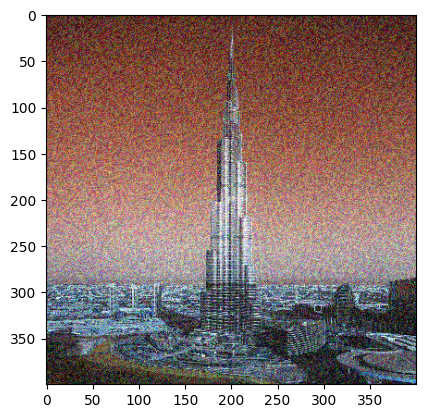

Epoch 250 


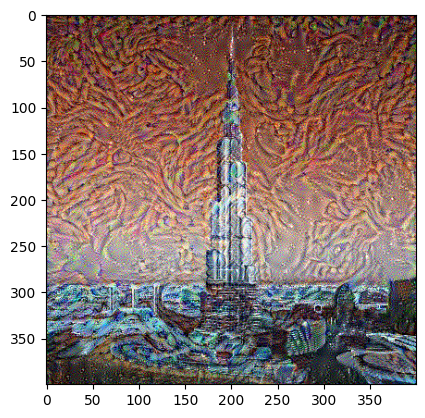

Epoch 500 


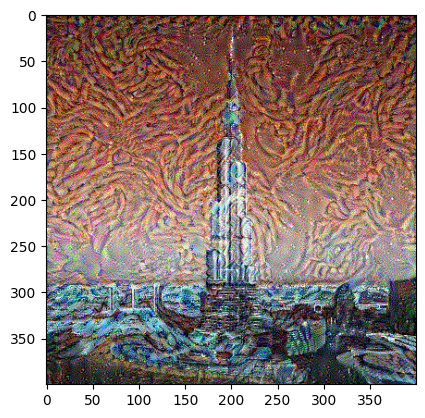

In [ ]:
epochs = 10001
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
        image = tensor_to_image_cv(generated_image)
        plt.imshow(image)
        plt.show()